In [2]:
import sys
import os

try:
    # If running from a .py file
    base_path = os.path.dirname(__file__)
except NameError:
    # If running in Jupyter Notebook
    base_path = os.getcwd()

project_root = os.path.abspath(os.path.join(base_path, "..", ".."))
sys.path.append(project_root)

from rsp.ReliableSpacePredictor import *
import matplotlib
from matplotlib.ticker import MaxNLocator

/Applications/anaconda3/envs/lube/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [3]:
def parity_plot(y_test1, y_pred_test1, start, end):
    matplotlib.rcParams['font.family'] = 'Helvetica'
    r2_test = r2_score(y_test1, y_pred_test1)
    rmse_test = np.sqrt(mean_squared_error(y_test1, y_pred_test1))
    
    # Print R^2 and RMSE

    print(f'R2 (Test): {r2_test}')
    print(f'RMSE (Test): {rmse_test}')
    
    # Plot predictions vs actual values
    plt.figure(figsize = [8,8])
    plt.scatter(y_test1, y_pred_test1, s = 70,  color = 'r')
    plt.plot([start, end], [start, end], color='black')
    plt.xlim([start, end])
    plt.ylim([start, end])
    plt.xlabel("Experimental KV40 (cSt)", fontsize = 25)
    plt.ylabel("Predicted KV40 (cSt)", fontsize = 25)
    # plt.legend()
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)     

        # Getting the current axes
    ax = plt.gca()

    # Setting the number of ticks on the x and y axes
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5)) # For x-axis, aiming for 5 ticks
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5)) # For y-axis, aiming for 6 ticks     
    plt.show()

In [4]:
df_train = pd.read_excel('../../Data/lubricants/kv40-train.xlsx')
df_test = pd.read_excel('../../Data/lubricants/kv40-test.xlsx')
X_train = pd.read_csv('../../Data/lubricants/kv40-train_descriptors.csv')
X_test = pd.read_csv('../../Data/lubricants/kv40-test_descriptors.csv')

In [5]:
# Find common columns
common_cols = X_test.columns.intersection(X_train.columns)

# Keep only the common columns
X_train = X_train[common_cols]

# y_vals
y_train = df_train['KV40 (cSt)'].to_numpy()
y_test = df_test['KV40 (cSt)'].to_numpy()

# smis
smis_train = df_train['Smiles'].to_numpy()
smis_test = df_test['Smiles'].to_numpy()

Model w/o structure-property space identification

In [171]:
model_global

XGBRegressor(alpha=0.0002426316624616729, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=3.079007748887745, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=8.100756250735851e-08,
             learning_rate=0.08370629658669083, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=24,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=116, n_jobs=None, ...)

In [8]:
X_train_uncorr = remove_corr_features(X_train)
rfe_results_global = select_features_rfecv(X_train_uncorr, y_train, model_type='regressor', cv_folds=10)
selected_descriptors_global = X_train_uncorr.columns[rfe_results_global['selected_mask']].to_list()
X_test_selected_global = X_test[selected_descriptors_global]
X_train_selected_global = X_train_uncorr[selected_descriptors_global]
X_train_selected_global_numpy = X_train_selected_global.values
X_test_selected_global_numpy = X_test_selected_global.values
study_global = optuna.create_study(direction='minimize')
study_global.optimize(lambda trial: xgboost_objective(trial, X_train_selected_global_numpy, y_train, 10), n_trials=100)
best_params_global = study_global.best_trial.params
model_global = xgb.XGBRegressor(**best_params_global)
model_global.fit(X_train_selected_global, y_train)
y_test_pred_global = model_global.predict(X_test_selected_global_numpy)
test_rmse_global = np.sqrt(mean_squared_error(y_test, y_test_pred_global))

Input shape: (86, 454)
Step 1: Selecting top 30 features using RandomForestRegressor importance...
Reduced shape: (86, 30)
Step 2: Applying RFECV on reduced feature set...


[I 2025-04-21 13:54:48,914] A new study created in memory with name: no-name-f65443a2-917d-43ab-8bf8-6db9a1ca7275
[I 2025-04-21 13:54:48,954] Trial 0 finished with value: 4.14301974591805 and parameters: {'lambda': 8.531114602485246e-05, 'alpha': 5.047709313665794e-07, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2363960287371775, 'n_estimators': 130, 'max_depth': 1, 'min_child_weight': 10, 'gamma': 5.6397128359615545, 'max_leaves': 29}. Best is trial 0 with value: 4.14301974591805.
[I 2025-04-21 13:54:49,016] Trial 1 finished with value: 5.165932743880203 and parameters: {'lambda': 2.285793504100207e-06, 'alpha': 0.074338269526007, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.0068026267388835064, 'n_estimators': 163, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 6.238262083479215, 'max_leaves': 32}. Best is trial 0 with value: 4.14301974591805.
[I 2025-04-21 13:54:49,055] Trial 2 finished with value: 6.893578382176355 and parameters: {'lambda': 0.00


Number of features selected: 30

Selected features: ['Ipc', 'exactmw', 'VSA_EState5', 'lipinskiHBD', 'ATSC3se', 'EState_VSA1', 'ATSC4Z', 'ATSC1se', 'PEOE_VSA7', 'ATSC3c', 'ATSC6Z', 'ATSC4dv', 'SpMAD_A', 'ATSC8d', 'VSA_EState4', 'MDEC-22', 'GATS3c', 'GATS1c', 'JGI6', 'ATSC2d', 'ATSC5d', 'GATS3d', 'lipinskiHBA', 'JGI9', 'n6ARing', 'VSA_EState8', 'fr_Al_COO', 'BalabanJ', 'EState_VSA3', 'ATSC3v']


[I 2025-04-21 13:54:49,121] Trial 4 finished with value: 4.158679595170591 and parameters: {'lambda': 0.46664148887825424, 'alpha': 0.07109318428885751, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.06582267525971311, 'n_estimators': 168, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 1.8610348276495081, 'max_leaves': 82}. Best is trial 0 with value: 4.14301974591805.
[I 2025-04-21 13:54:49,148] Trial 5 finished with value: 5.299004099781849 and parameters: {'lambda': 0.00015675839807877606, 'alpha': 1.839970323763205e-07, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.023148537532647416, 'n_estimators': 124, 'max_depth': 1, 'min_child_weight': 7, 'gamma': 2.955998795946134, 'max_leaves': 48}. Best is trial 0 with value: 4.14301974591805.
[I 2025-04-21 13:54:49,175] Trial 6 finished with value: 3.84393289082102 and parameters: {'lambda': 0.0001161786762225408, 'alpha': 1.4249398992078599e-05, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.

In [172]:
to_save_global = {
    'X_train_uncorr': X_train_uncorr,
    'rfe_results_global': rfe_results_global,
    'selected_descriptors_global': selected_descriptors_global,
    'X_test_selected_global': X_test_selected_global,
    'X_train_selected_global': X_train_selected_global,
    'X_train_selected_global_numpy': X_train_selected_global_numpy,
    'X_test_selected_global_numpy': X_test_selected_global_numpy,
    'study_global': study_global,
    'best_params_global': best_params_global,
    'model_global': model_global,
    'y_test_pred_global': y_test_pred_global,
    'test_rmse_global': test_rmse_global
}

with open('lubricants_global_model_pipeline.pkl', 'wb') as f:
    pickle.dump(to_save_global, f)

In [9]:
print(f"Test RMSE: {test_rmse_global}")

Test RMSE: 4.44999484474533


R2 (Test): -0.27670779916047206
RMSE (Test): 4.44999484474533


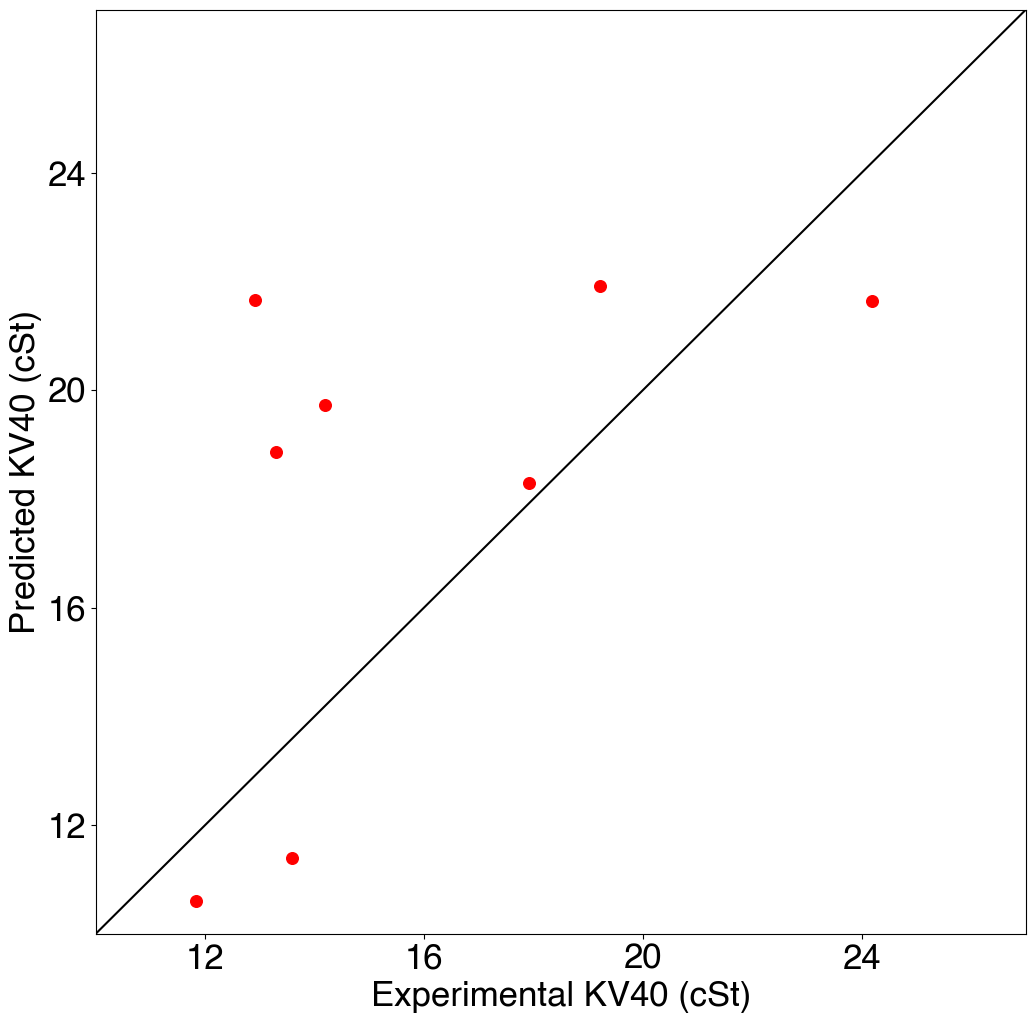

In [10]:
parity_plot(y_test, y_test_pred_global, 10, 27)

Model with defined structure-property space

In [15]:
RSP = ReliableSpacePredictor(cv_folds=10, 
                             n_trials_distance = 10, 
                             n_trials_model_optimization=100,
                             threshold_range=[1.0, 2.0], 
                             model_type='xgb')
base_3D = RSP.define_space_from_target_only(smis_test, smis_train, X_train, y_train)
best_study = RSP.select_data_for_target_space(smis_test, smis_train, X_train, y_train)
distances_train_RSP = RSP.distances
train_rmse_RSP = RSP.best_mean_rmse
model_RSP = RSP.best_model

model_params_RSP = RSP.model_params
n_original_train_data = X_train.shape[0]
n_selected_train_data = RSP.X_RSP_optimized.shape[0]
drop_rate = 1 - n_selected_train_data/n_original_train_data
selected_descriptors_RSP = X_train.columns[RSP.best_feature_mask].to_list()
y_train_RSP_optimized = RSP.y_RSP_optimized
X_test_selected_RSP = X_test[selected_descriptors_RSP]

y_test_pred_RSP = model_RSP.predict(X_test_selected_RSP)
test_rmse_RSP = np.sqrt(mean_squared_error(y_test, y_test_pred_RSP))

Generating fingerprints...
Generating fingerprints...
Generating fingerprints...
Generating fingerprints...


[I 2025-04-21 13:58:52,705] A new study created in memory with name: no-name-89967ccf-176b-42b6-8f04-d916d38eaaac


Starting optimization with 10 trials...
Trial 0: Selected 86 molecules with threshold 1.57
Performing feature selection...


[I 2025-04-21 13:58:55,756] A new study created in memory with name: no-name-12063964-d910-4850-91f6-636509d7f1cf
[I 2025-04-21 13:58:55,792] Trial 0 finished with value: 4.217269204803995 and parameters: {'lambda': 0.004717581313738586, 'alpha': 0.5849594141733615, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.04905687822645115, 'n_estimators': 103, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 1.301696521607132, 'max_leaves': 33}. Best is trial 0 with value: 4.217269204803995.
[I 2025-04-21 13:58:55,820] Trial 1 finished with value: 4.015214486401009 and parameters: {'lambda': 0.4927491580827276, 'alpha': 4.219320226448625e-08, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.24415817124505193, 'n_estimators': 60, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 5.439077189704788, 'max_leaves': 42}. Best is trial 1 with value: 4.015214486401009.
[I 2025-04-21 13:58:55,871] Trial 2 finished with value: 8.181691512876016 and parameters: {'lambda': 0.000185

Trial 0: RMSE = 3.2284, Coverage = 0.9767, Loss = 3.3147
Best score updated to 3.314734420237764 from inf
Trial 1/10 completed | Best score so far: 3.3147
Trial 1: Selected 81 molecules with threshold 1.94
Performing feature selection...


[I 2025-04-21 13:59:05,228] A new study created in memory with name: no-name-2a72c2a5-db45-40e0-8464-d777bf8bd82f
[I 2025-04-21 13:59:05,267] Trial 0 finished with value: 3.256450270279012 and parameters: {'lambda': 0.0002941999095476026, 'alpha': 1.1892400418234829e-07, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.07438243049215063, 'n_estimators': 105, 'max_depth': 2, 'min_child_weight': 5, 'gamma': 1.8394341781698564, 'max_leaves': 47}. Best is trial 0 with value: 3.256450270279012.
[I 2025-04-21 13:59:05,294] Trial 1 finished with value: 3.0307527380880543 and parameters: {'lambda': 7.619191558785257e-06, 'alpha': 0.5503757244547901, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.17458720625325427, 'n_estimators': 75, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 7.70789863959214, 'max_leaves': 51}. Best is trial 1 with value: 3.0307527380880543.
[I 2025-04-21 13:59:05,320] Trial 2 finished with value: 2.9978447774565646 and parameters: {'lambda': 

Trial 1: RMSE = 2.3480, Coverage = 0.9753, Loss = 2.4074
Best score updated to 2.407391852482829 from 3.314734420237764
Trial 2/10 completed | Best score so far: 2.4074
Trial 2: Selected 75 molecules with threshold 1.32
Performing feature selection...


[I 2025-04-21 13:59:13,590] A new study created in memory with name: no-name-facba884-f976-46f6-b61e-b1db100ee809
[I 2025-04-21 13:59:13,640] Trial 0 finished with value: 5.0175828972016525 and parameters: {'lambda': 0.001961166754939461, 'alpha': 6.387994502260248e-05, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0010636601752394132, 'n_estimators': 181, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 2.7264228668738113, 'max_leaves': 10}. Best is trial 0 with value: 5.0175828972016525.
[I 2025-04-21 13:59:13,680] Trial 1 finished with value: 3.3836904696869183 and parameters: {'lambda': 0.1919878816259538, 'alpha': 0.0785447143717852, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.007791814201577418, 'n_estimators': 166, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 6.429130156041771, 'max_leaves': 81}. Best is trial 1 with value: 3.3836904696869183.
[I 2025-04-21 13:59:13,715] Trial 2 finished with value: 4.100203418257127 and parameters: {'lambda':

Trial 2: RMSE = 1.6984, Coverage = 1.0000, Loss = 1.7833
Best score updated to 1.7833373739244178 from 2.407391852482829
Trial 3/10 completed | Best score so far: 1.7833
Trial 3: Selected 78 molecules with threshold 1.39
Performing feature selection...


[I 2025-04-21 13:59:22,238] A new study created in memory with name: no-name-29a2a576-ae9d-4063-871d-c932c93171b3
[I 2025-04-21 13:59:22,278] Trial 0 finished with value: 2.394051818416884 and parameters: {'lambda': 0.002611577632612835, 'alpha': 0.023251319571663327, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.1832534492271075, 'n_estimators': 114, 'max_depth': 1, 'min_child_weight': 2, 'gamma': 0.48883735558217234, 'max_leaves': 92}. Best is trial 0 with value: 2.394051818416884.
[I 2025-04-21 13:59:22,316] Trial 1 finished with value: 4.800365360918502 and parameters: {'lambda': 1.2545935562757458e-08, 'alpha': 0.013714402659018557, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.003456080073157781, 'n_estimators': 114, 'max_depth': 4, 'min_child_weight': 1, 'gamma': 6.560307151401808, 'max_leaves': 47}. Best is trial 0 with value: 2.394051818416884.
[I 2025-04-21 13:59:22,344] Trial 2 finished with value: 3.5035649839229364 and parameters: {'lambda':

Trial 3: RMSE = 2.0285, Coverage = 0.9744, Loss = 2.0779
Trial 4/10 completed | Best score so far: 1.7833
Trial 4: Selected 86 molecules with threshold 1.96
Performing feature selection...


[I 2025-04-21 13:59:29,530] A new study created in memory with name: no-name-49c11867-4d38-4412-91c9-1cd64f36606e
[I 2025-04-21 13:59:29,592] Trial 0 finished with value: 4.9526004709577 and parameters: {'lambda': 0.10023617365476654, 'alpha': 0.21526441111202357, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.0105605173273143, 'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 7, 'gamma': 9.69805857251568, 'max_leaves': 23}. Best is trial 0 with value: 4.9526004709577.
[I 2025-04-21 13:59:29,632] Trial 1 finished with value: 6.306662959942618 and parameters: {'lambda': 0.0009576626682463523, 'alpha': 6.24232498695378e-08, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.008278493235867436, 'n_estimators': 115, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 7.000467766209164, 'max_leaves': 100}. Best is trial 0 with value: 4.9526004709577.
[I 2025-04-21 13:59:29,672] Trial 2 finished with value: 6.915657729587963 and parameters: {'lambda': 0.001312103

Trial 4: RMSE = 3.5045, Coverage = 0.9884, Loss = 3.6390
Trial 5/10 completed | Best score so far: 1.7833
Trial 5: Selected 82 molecules with threshold 1.81
Performing feature selection...


[I 2025-04-21 13:59:37,589] A new study created in memory with name: no-name-b04a2cdd-1c38-415a-8792-56154f3147d2
[I 2025-04-21 13:59:37,640] Trial 0 finished with value: 4.686921064743575 and parameters: {'lambda': 7.173708405556446e-06, 'alpha': 3.4933173332979393e-06, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.01029439872895919, 'n_estimators': 156, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 4.318055205941659, 'max_leaves': 16}. Best is trial 0 with value: 4.686921064743575.
[I 2025-04-21 13:59:37,687] Trial 1 finished with value: 3.5233557651743688 and parameters: {'lambda': 0.008894411753109186, 'alpha': 0.0007939175778334092, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.04822984237816941, 'n_estimators': 178, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 4.77529048273123, 'max_leaves': 99}. Best is trial 1 with value: 3.5233557651743688.
[I 2025-04-21 13:59:37,714] Trial 2 finished with value: 7.58995203284599 and parameters: {'lambda':

Trial 5: RMSE = 3.1977, Coverage = 0.9756, Loss = 3.2796
Trial 6/10 completed | Best score so far: 1.7833
Trial 6: Selected 75 molecules with threshold 1.17
Performing feature selection...


[I 2025-04-21 13:59:47,135] A new study created in memory with name: no-name-570975a3-078a-4c0c-81e3-10ddc269fd5e
[I 2025-04-21 13:59:47,186] Trial 0 finished with value: 4.416132748361188 and parameters: {'lambda': 0.00011185089686496674, 'alpha': 0.0012371727787274256, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.0022272450727880595, 'n_estimators': 172, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 5.807459531799348, 'max_leaves': 35}. Best is trial 0 with value: 4.416132748361188.
[I 2025-04-21 13:59:47,212] Trial 1 finished with value: 5.489550802619205 and parameters: {'lambda': 0.7105928293758182, 'alpha': 1.932542742167071e-06, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.0015364654727534454, 'n_estimators': 50, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 1.352335310971493, 'max_leaves': 43}. Best is trial 0 with value: 4.416132748361188.
[I 2025-04-21 13:59:47,248] Trial 2 finished with value: 5.166754592861996 and parameters: {'lambda':

Trial 6: RMSE = 1.6273, Coverage = 0.9733, Loss = 1.6653
Best score updated to 1.6652654057952052 from 1.7833373739244178
Trial 7/10 completed | Best score so far: 1.6653
Trial 7: Selected 82 molecules with threshold 1.82
Performing feature selection...


[I 2025-04-21 13:59:54,199] A new study created in memory with name: no-name-fa76c664-5eb5-428b-8d18-5ba32f3cf985
[I 2025-04-21 13:59:54,236] Trial 0 finished with value: 3.8028155375372164 and parameters: {'lambda': 0.002900026245069394, 'alpha': 0.8693424256049537, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.161018460104157, 'n_estimators': 143, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 2.9194145559770113, 'max_leaves': 74}. Best is trial 0 with value: 3.8028155375372164.
[I 2025-04-21 13:59:54,287] Trial 1 finished with value: 3.7599456520730756 and parameters: {'lambda': 0.0001938618002446966, 'alpha': 3.837652371170597e-07, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.0838553964361191, 'n_estimators': 161, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 0.3898970400955504, 'max_leaves': 35}. Best is trial 1 with value: 3.7599456520730756.
[I 2025-04-21 13:59:54,322] Trial 2 finished with value: 3.6346882632726234 and parameters: {'lambda': 

Trial 7: RMSE = 2.9841, Coverage = 0.9756, Loss = 3.0605
Trial 8/10 completed | Best score so far: 1.6653
Trial 8: Selected 81 molecules with threshold 1.01
Performing feature selection...


[I 2025-04-21 14:00:03,644] A new study created in memory with name: no-name-ca9eea4c-8ced-46ca-8198-5c10805d02fe
[I 2025-04-21 14:00:03,671] Trial 0 finished with value: 4.410663762954844 and parameters: {'lambda': 0.23534238020900955, 'alpha': 3.881152536064898e-08, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.018264238502718196, 'n_estimators': 97, 'max_depth': 2, 'min_child_weight': 5, 'gamma': 5.239074420073939, 'max_leaves': 86}. Best is trial 0 with value: 4.410663762954844.
[I 2025-04-21 14:00:03,699] Trial 1 finished with value: 6.841869668704616 and parameters: {'lambda': 0.24566242618597015, 'alpha': 1.1906143639217677e-08, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.002386841427446733, 'n_estimators': 64, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 6.5315277455206555, 'max_leaves': 25}. Best is trial 0 with value: 4.410663762954844.
[I 2025-04-21 14:00:03,737] Trial 2 finished with value: 3.900272937503324 and parameters: {'lambda': 2.

Trial 8: RMSE = 2.3110, Coverage = 0.9630, Loss = 2.3410
Trial 9/10 completed | Best score so far: 1.6653
Trial 9: Selected 85 molecules with threshold 1.60
Performing feature selection...


[I 2025-04-21 14:00:10,795] A new study created in memory with name: no-name-db3e3899-af8d-4f03-ae42-967cff3ec44e
[I 2025-04-21 14:00:10,880] Trial 0 finished with value: 4.225427878550533 and parameters: {'lambda': 0.006498496857867281, 'alpha': 0.041169939346290964, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.028857914658868056, 'n_estimators': 191, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 1.4291406750847202, 'max_leaves': 29}. Best is trial 0 with value: 4.225427878550533.
[I 2025-04-21 14:00:10,906] Trial 1 finished with value: 7.173248280343445 and parameters: {'lambda': 0.0023933603600941097, 'alpha': 3.68833430434734e-08, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.009087685279479906, 'n_estimators': 53, 'max_depth': 3, 'min_child_weight': 8, 'gamma': 1.7841000429497467, 'max_leaves': 35}. Best is trial 0 with value: 4.225427878550533.
[I 2025-04-21 14:00:10,942] Trial 2 finished with value: 7.411635475233351 and parameters: {'lambda': 

Trial 9: RMSE = 3.4323, Coverage = 0.9882, Loss = 3.5635
Trial 10/10 completed | Best score so far: 1.6653
Selected 75 samples from training dataset


In [105]:
# Calculate uncertainty estimates
Reff = RSP.optimal_threshold
dcp = RSP.best_dcp
weights_distance = RSP.optimal_weights

fps_test = RSP.generate_fingerprints(smis_test)
X_2d_test = RSP.pca.transform(fps_test)
y_test_scaled = RSP.scaler(y_test)
y_test_pred_RSP_scaled = RSP.scaler(y_test_pred_RSP)
y_test_pred_global_scaled = RSP.scaler(y_test_pred_global)
X_3d_test = np.column_stack([X_2d_test, y_test_scaled])
X_3d_test_pred_RSP = np.column_stack([X_2d_test, y_test_pred_RSP_scaled])
X_3d_test_pred_global = np.column_stack([X_2d_test, y_test_pred_global_scaled])     
distances_test = RSP.get_distances(X_3d_test, weights_distance)
distances_test_pred_RSP = RSP.get_distances(X_3d_test_pred_RSP, weights_distance)
distances_test_pred_global = RSP.get_distances(X_3d_test_pred_global, weights_distance)
lambda_RSP = RSP.optimal_lambda
lower_dcp, upper_dcp = dcp.predict_interval(y_test_pred_RSP, lambda_RSP, distances_test_pred_RSP)
coverage_dcp = dcp.get_coverage(y_test, lower_dcp, upper_dcp)

fcp = FixedConformalPredictor(confidence=0.95)
fcp.fit(y_train_RSP_optimized, RSP.best_cv_predictions)
lower_fcp, upper_fcp = fcp.predict_interval(y_test_pred_RSP)
coverage_fcp = fcp.get_coverage(y_test, lower_fcp, upper_fcp)

Generating fingerprints...


In [175]:
# --- SAVE ALL VARIABLES USING PICKLE ---
to_save_local = {
    'RSP': RSP,
    'base_3D': base_3D,
    'best_study': best_study,
    'distances_train_RSP': distances_train_RSP,
    'train_rmse_RSP': train_rmse_RSP,
    'model_RSP': model_RSP,
    'model_params_RSP': model_params_RSP,
    'n_original_train_data': n_original_train_data,
    'n_selected_train_data': n_selected_train_data,
    'drop_rate': drop_rate,
    'selected_descriptors_RSP': selected_descriptors_RSP,
    'y_train_RSP_optimized': y_train_RSP_optimized,
    'X_test_selected_RSP': X_test_selected_RSP,
    'y_test_pred_RSP': y_test_pred_RSP,
    'test_rmse_RSP': test_rmse_RSP,
    'Reff': Reff,
    'dcp': dcp,
    'weights_distance': weights_distance,
    'fps_test': fps_test,
    'X_2d_test': X_2d_test,
    'y_test_scaled': y_test_scaled,
    'y_test_pred_RSP_scaled': y_test_pred_RSP_scaled,
    'y_test_pred_global_scaled': y_test_pred_global_scaled,
    'X_3d_test': X_3d_test,
    'X_3d_test_pred_RSP': X_3d_test_pred_RSP,
    'X_3d_test_pred_global': X_3d_test_pred_global,
    'distances_test': distances_test,
    'distances_test_pred_RSP': distances_test_pred_RSP,
    'distances_test_pred_global': distances_test_pred_global,
    'lambda_RSP': lambda_RSP,
    'lower_dcp': lower_dcp,
    'upper_dcp': upper_dcp,
    'coverage_dcp': coverage_dcp,
    'fcp': fcp,
    'lower_fcp': lower_fcp,
    'upper_fcp': upper_fcp,
    'coverage_fcp': coverage_fcp
}

with open('lubricants_local_model_pipeline.pkl', 'wb') as f:
    pickle.dump(to_save_local, f)

In [148]:
Reff

1.1677857934128468

In [62]:
len(distances_train_RSP)

75

In [146]:
(test_rmse_global - test_rmse_RSP)/test_rmse_global*100

28.74833758103923

In [16]:
print(f"Test RMSE: {test_rmse_RSP}")

Test RMSE: 3.1706953044391


In [58]:
fps_train = RSP.generate_fingerprints(smis_train)
X_2d_train = RSP.pca.transform(fps_train)
y_train_scaled = RSP.scaler(y_train)
# y_train_pred_RSP_scaled = RSP.scaler(y_train_pred_RSP)
# y_test_pred_global_scaled = RSP.scaler(y_train_pred_global)
X_3d_train = np.column_stack([X_2d_train, y_train_scaled])
distances_train = RSP.get_distances(X_3d_train, weights_distance)

Generating fingerprints...


In [170]:
(0.73-0.33)/np.sqrt(0.33*0.67/499)

19.002725410947544

In [63]:
np.var(distances_train_RSP)

0.058042954903137156

In [65]:
np.var(abs(y_train_RSP_optimized - RSP.best_cv_predictions))

1.999975082954301

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7'),
  Text(0, 8.0, '8')])

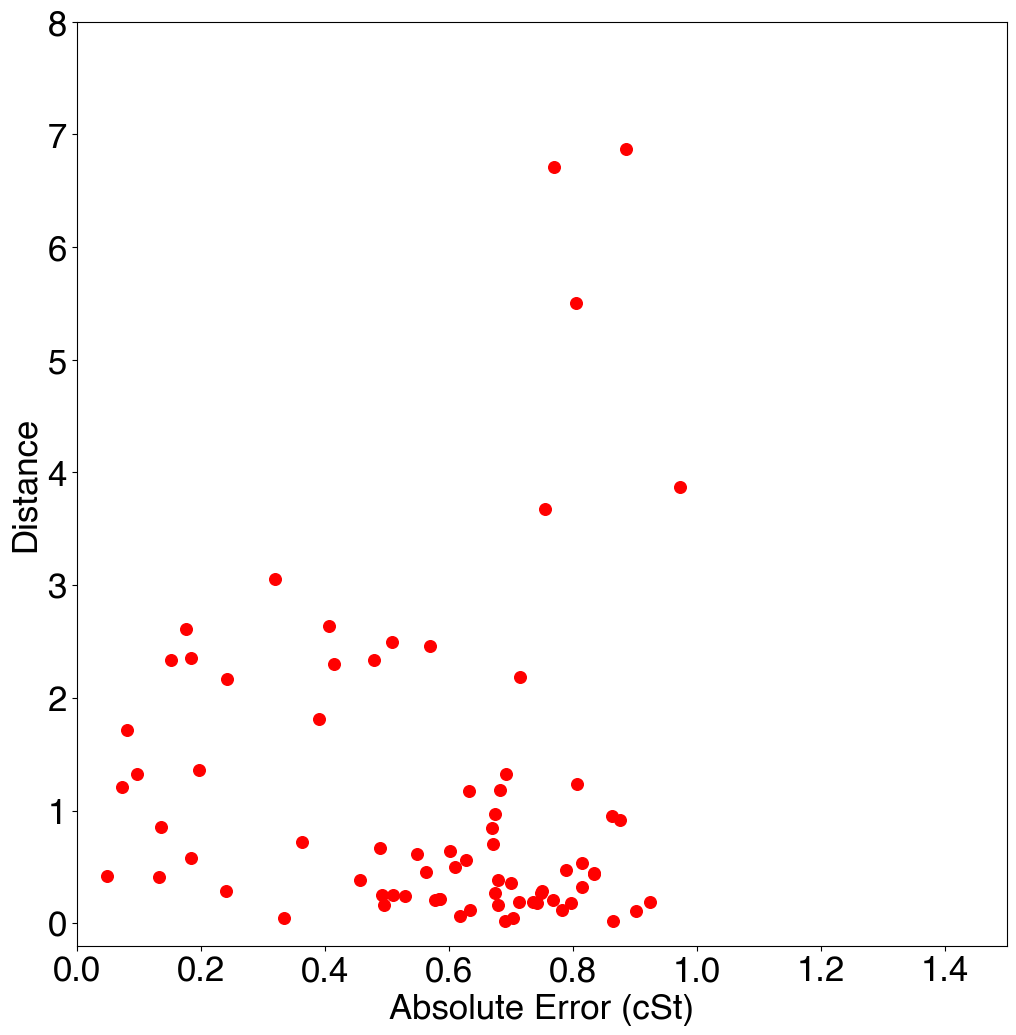

In [21]:
# Plot predictions vs actual values
plt.figure(figsize = [12,12])
plt.scatter(distances_train_RSP, abs(y_train_RSP_optimized - RSP.best_cv_predictions), s = 70,  color = 'r')
plt.xlim([0, 1.5])
plt.ylim([-0.2, 8])
plt.xlabel("Absolute Error (cSt)", fontsize = 25)
plt.ylabel("Distance", fontsize = 25)
# plt.legend()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)     

(array([44., 13.,  2., 10.,  1.,  2.,  0.,  0.,  1.,  2.]),
 array([0.01501269, 0.70041652, 1.38582034, 2.07122417, 2.75662799,
        3.44203182, 4.12743564, 4.81283947, 5.49824329, 6.18364712,
        6.86905094]),
 <BarContainer object of 10 artists>)

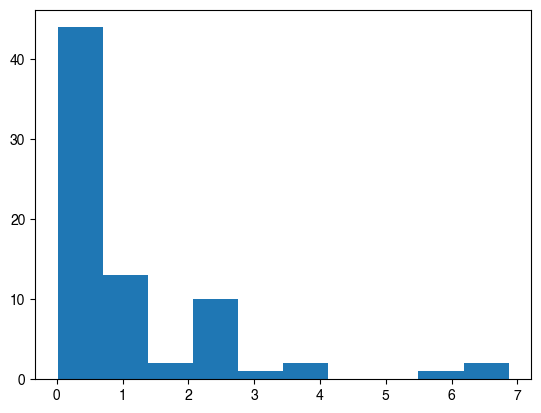

In [22]:
plt.hist(abs(y_train_RSP_optimized - RSP.best_cv_predictions))

In [26]:
parity_plot(distances_train_RSP, abs(y_train_RSP_optimized - RSP.best_cv_predictions))

TypeError: parity_plot() missing 2 required positional arguments: 'start' and 'end'

In [64]:
np.var(distances_test)

0.10777961260799668

In [54]:
np.var(distances_test)

0.10777961260799668

In [66]:
np.var(abs(y_test - y_test_pred_RSP))

3.798950711585408

In [61]:
len(distances_train)

86

In [68]:
pearsonr(distances_train_RSP, abs(y_train_RSP_optimized - RSP.best_cv_predictions))[0]

-0.007656154176534085

In [30]:
pearsonr(distances_test, abs(y_test - y_test_pred_RSP))[0]

0.6226663991612617

In [162]:
y_err_fcp 

array([5.5066147, 5.5066147, 5.5066147, 5.5066147, 5.5066147, 5.5066147,
       5.5066147, 5.5066147], dtype=float32)

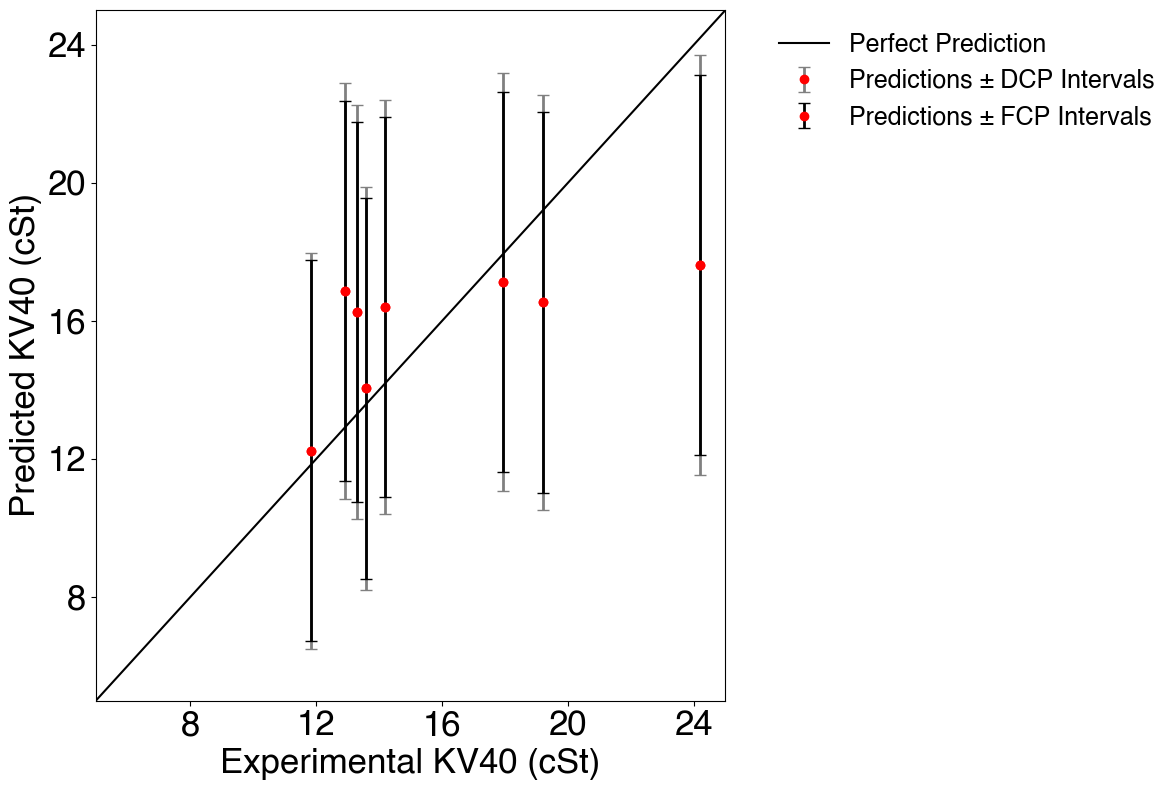

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# Set font
plt.rcParams['font.family'] = 'Helvetica'

# Optional: if you don't have per-point uncertainty, use a constant RMSE for all
# rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_RSP))
# y_err = np.full_like(y_test_pred_RSP, rmse)
y_err_dcp = (upper_dcp - lower_dcp)/2
y_err_fcp = (upper_fcp - lower_fcp)/2
# Plot
plt.figure(figsize=[12, 8])
plt.errorbar(
    y_test, y_test_pred_RSP, 
    yerr=y_err_dcp, fmt='o', 
    color='red', ecolor='gray', elinewidth=2, capsize=4, label='Predictions ± DCP Intervals'
)
plt.errorbar(
    y_test, y_test_pred_RSP, 
    yerr=y_err_fcp, fmt='o', 
    color='red', ecolor='k', elinewidth=2, capsize=4, label='Predictions ± FCP Intervals'
)
# Parity line
start, end = [5, 25]
plt.plot([start, end], [start, end], color='black', label='Perfect Prediction')

# Labels & ticks
plt.xlim([start, end])
plt.ylim([start, end])
plt.xlabel("Experimental KV40 (cSt)", fontsize=25)
plt.ylabel("Predicted KV40 (cSt)", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Ticks and grid
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1.05, 1.0), frameon=False)
plt.tight_layout()
plt.show()


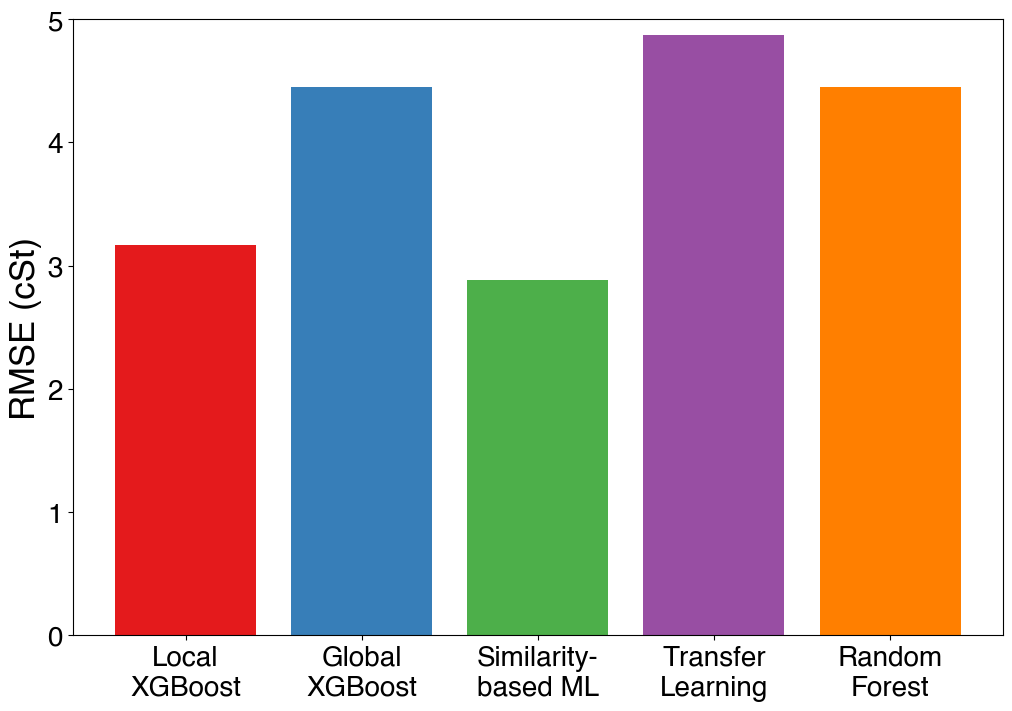

In [138]:
# Predicted to be in domain
categories = [
    'Local\nXGBoost', 
    'Global\nXGBoost', 
    'Similarity-\nbased ML', 
    'Transfer\nLearning', 
    'Random\nForest'
]
lube_RMSE = np.array([3.17 , 4.45,  2.88, 4.87, 4.45])
color_list = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

x = np.arange(len(categories))
# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Updated colors
ax.bar(x, lube_RMSE, color=color_list)  # Warm & vibrant
# ax.bar(x + width/2, CI_cov_fcp, width, color='seagreen')  # Cool & distinct
# ax.axhline(y=0.9, color='black', linestyle='dashed', linewidth=3)


# Labels, ticks, and title
ax.set_ylabel('RMSE (cSt)', fontsize=25, fontname='Helvetica')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=20, fontname='Helvetica')
# ax.set_xticklabels(categories, fontsize=20, fontname='Helvetica', rotation=20, ha='right')

# Adjust Y-axis ticks
ax.set_yticks(np.linspace(0, 5.0, 6))
ax.set_ylim(0.0, 5)
ax.tick_params(axis='y', labelsize=20)

plt.show()



(array([3., 0., 1., 1., 1., 1., 0., 0., 0., 1.]),
 array([0.40064255, 1.01691714, 1.63319174, 2.24946634, 2.86574094,
        3.48201553, 4.09829013, 4.71456473, 5.33083932, 5.94711392,
        6.56338852]),
 <BarContainer object of 10 artists>)

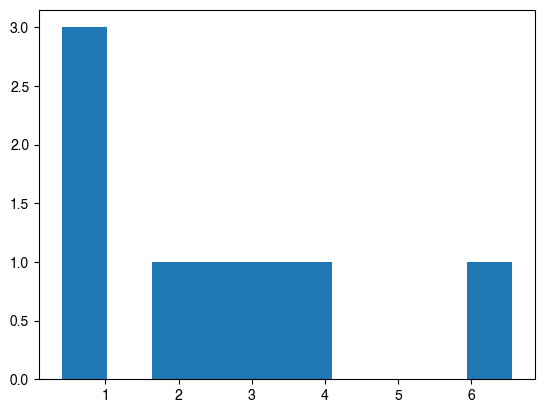

In [32]:
plt.hist(abs(y_test - y_test_pred_RSP))

In [33]:
y_test - y_test_pred_RSP

array([-3.95144447,  0.79739754, -0.40064255, -0.46206657,  2.67522713,
       -2.20998245, -2.94682236,  6.56338852])

R2 (Test): 0.35184106144825533
RMSE (Test): 3.1706953044391


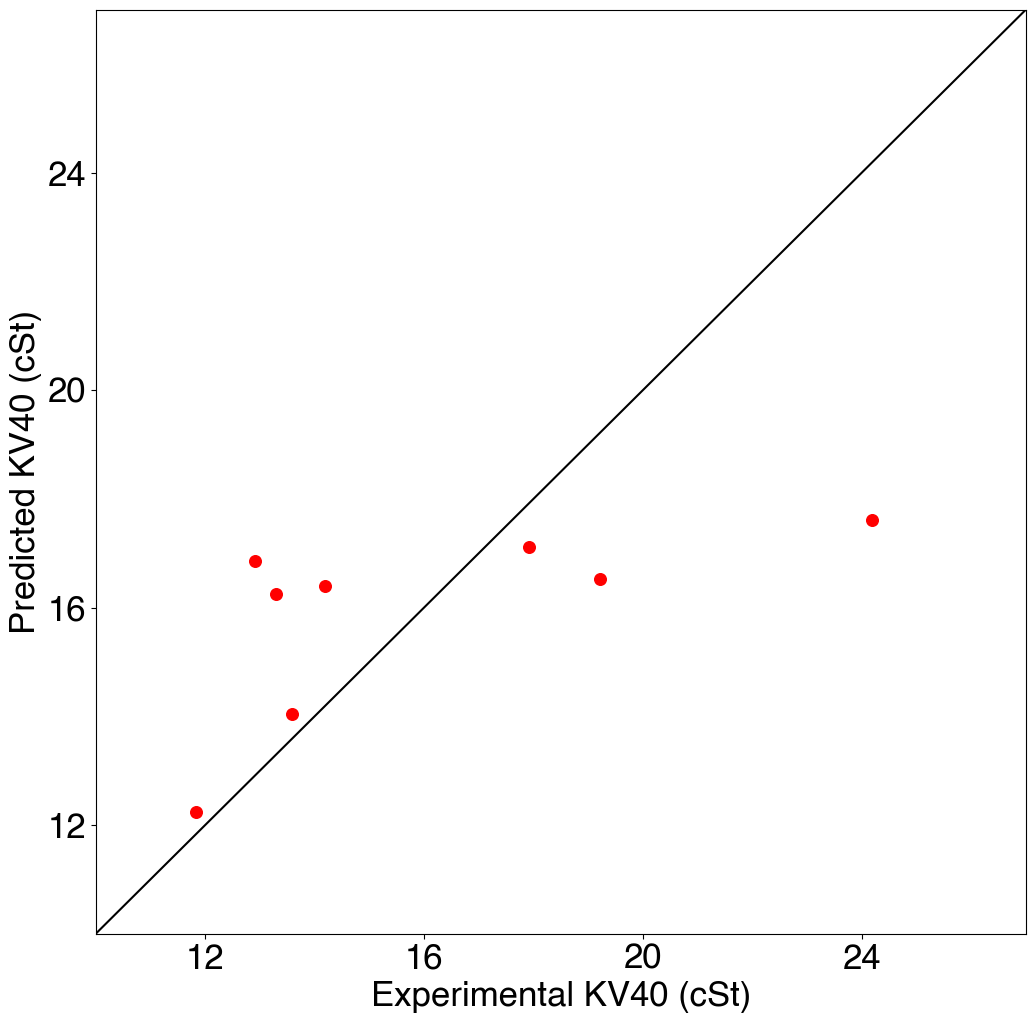

In [34]:
parity_plot(y_test, y_test_pred_RSP, 10, 27)

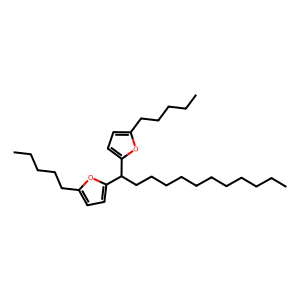

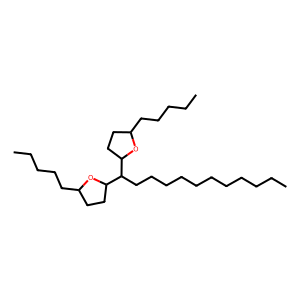

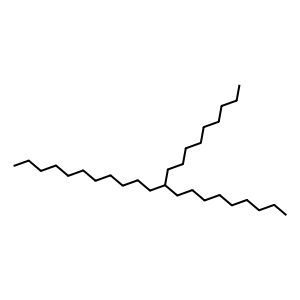

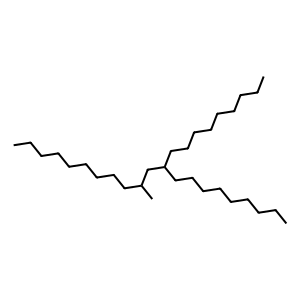

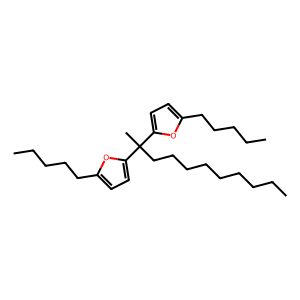

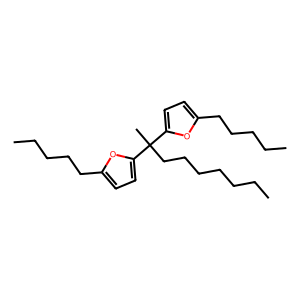

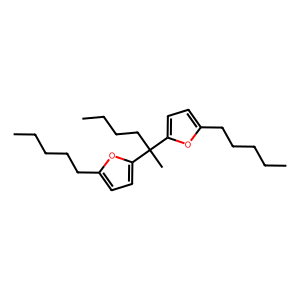

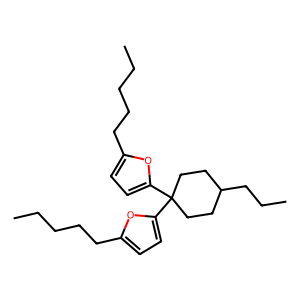

In [78]:
for smi in np.array(smis_test):
    m = Chem.MolFromSmiles(smi)
    image = Chem.Draw.MolToImage(m)
    display(image)

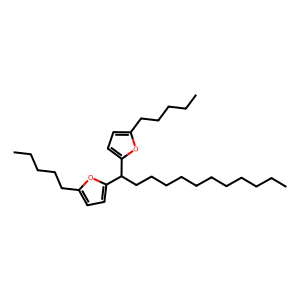

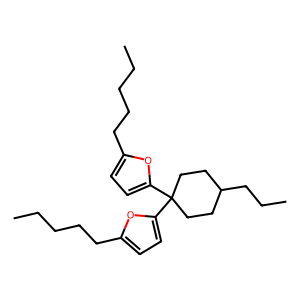

In [77]:
for smi in np.array(smis_test)[[0,7]]:
    m = Chem.MolFromSmiles(smi)
    image = Chem.Draw.MolToImage(m)
    display(image)

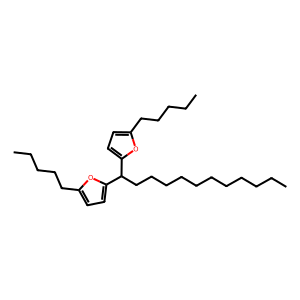

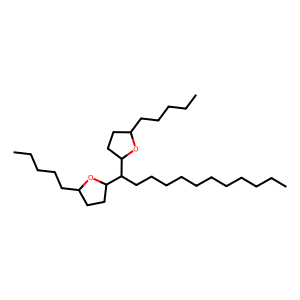

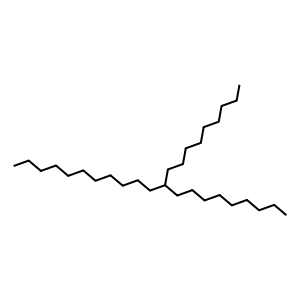

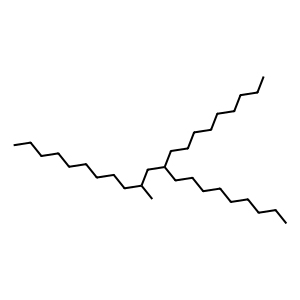

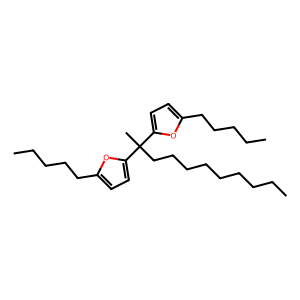

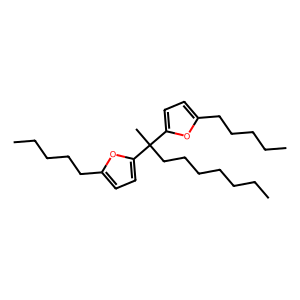

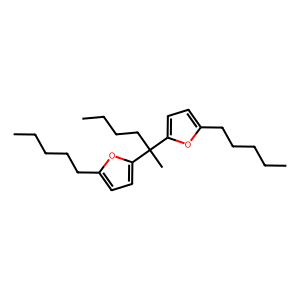

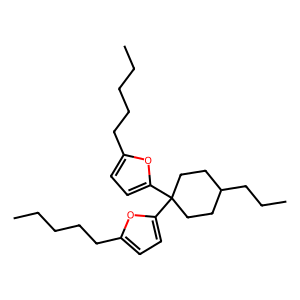

In [141]:
# Loop through selected SMILES
for smi in np.array(smis_test):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        Chem.rdDepictor.Compute2DCoords(mol)
        drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)  # width, height
        drawer.drawOptions().clearBackground = False  # This makes background transparent
        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        png_data = drawer.GetDrawingText()

        # Display image
        display(Image(data=png_data))

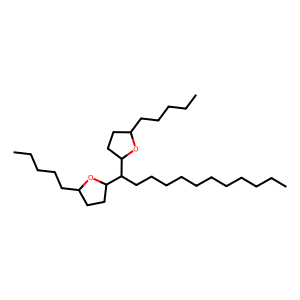

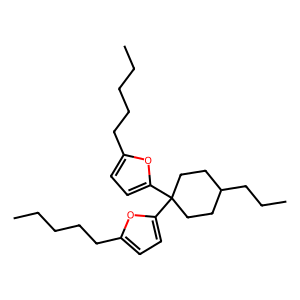

In [140]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import Image, display
import io

# Loop through selected SMILES
for smi in np.array(smis_test)[[1, 7]]:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        Chem.rdDepictor.Compute2DCoords(mol)
        drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)  # width, height
        drawer.drawOptions().clearBackground = False  # This makes background transparent
        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        png_data = drawer.GetDrawingText()

        # Display image
        display(Image(data=png_data))


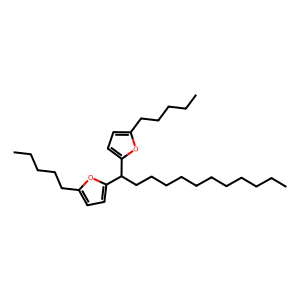

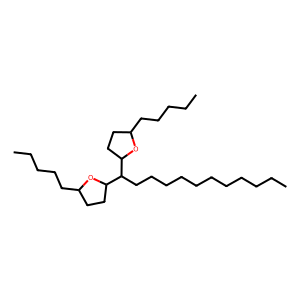

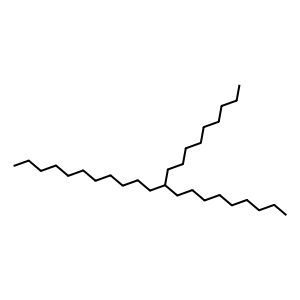

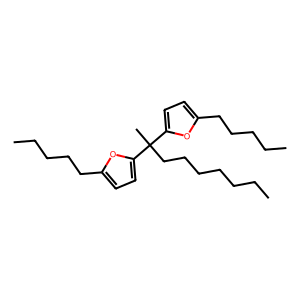

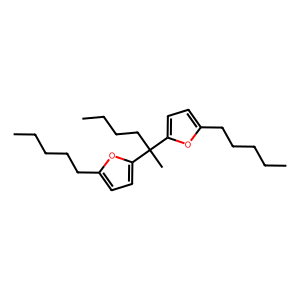

In [98]:
for smi in np.array(smis_test)[[0, 1, 2, 5, 6]]:
    m = Chem.MolFromSmiles(smi)
    image = Chem.Draw.MolToImage(m)
    display(image)

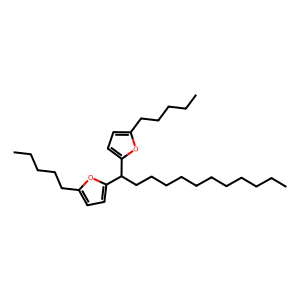

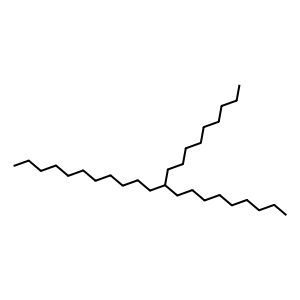

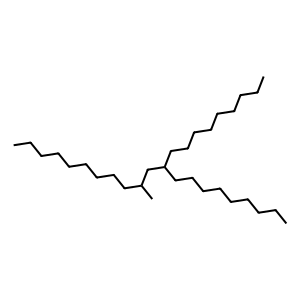

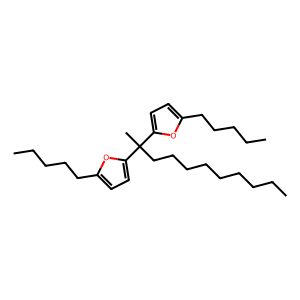

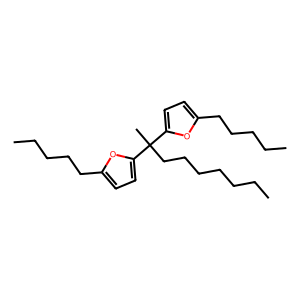

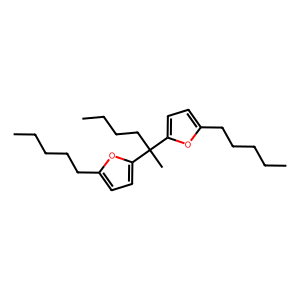

In [51]:
for smi in np.array(smis_test)[[0,2,3,4,5,6]]:
    m = Chem.MolFromSmiles(smi)
    image = Chem.Draw.MolToImage(m)
    display(image)

In [37]:
y_test - y_test_pred_RSP

array([-3.95144447,  0.79739754, -0.40064255, -0.46206657,  2.67522713,
       -2.20998245, -2.94682236,  6.56338852])

In [38]:
(test_rmse_global - test_rmse_RSP)/test_rmse_global*100

28.74833758103923

In [103]:
import numpy as np
import plotly.graph_objects as go

# --- Scatter Data ---
fig = go.Figure()
idx_well_predicted = [0,2,3,4,5,6]
idx_poorly_predicted = [1,7]
# Train points
# fig.add_trace(go.Scatter3d(
#     x=X_3d_train[:,0], y=X_3d_train[:,1], z=X_3d_train[:,2],
#     mode='markers',
#     name='Well-predicted',
#     marker=dict(size=5, color='green', opacity=0.6)
# ))
fig.add_trace(go.Scatter3d(
    x=X_3d_test[idx_well_predicted,0], y=X_3d_test[idx_well_predicted,1], z=X_3d_test[idx_well_predicted,2],
    mode='markers',
    name='Well-predicted',
    marker=dict(size=20, color='green', opacity=0.6)
))
# Test points
fig.add_trace(go.Scatter3d(
    x=X_3d_test[idx_poorly_predicted,0], y=X_3d_test[idx_poorly_predicted,1], z=X_3d_test[idx_poorly_predicted,2],
    mode='markers',
    name='Poorly-predicted',
    marker=dict(size=20, color='red', opacity=0.6)
))

# --- Ellipsoid ---
# Define grid for ellipsoid
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0, np.pi, 50)
u, v = np.meshgrid(u, v)
w1, w2, w3 = RSP.optimal_weights
# Radius & weights
a = Reff / np.sqrt(w1)
b = Reff / np.sqrt(w2)
c = Reff / np.sqrt(w3)

# Ellipsoid coordinates
ellip_x = a * np.cos(u) * np.sin(v)
ellip_y = b * np.sin(u) * np.sin(v)
ellip_z = c * np.cos(v)

# Center the ellipsoid (optional)
xc, yc, zc = RSP.centroid  # You can change this to your centroid if needed
ellip_x += xc
ellip_y += yc
ellip_z += zc

fig.add_trace(go.Surface(
    x=ellip_x,
    y=ellip_y,
    z=ellip_z,
    opacity=0.3,
    showscale=False,
    name='Ellipsoid',
    colorscale='Greys',
    hoverinfo='skip'
))

# --- Centroid Marker ---
fig.add_trace(go.Scatter3d(
    x=[xc], y=[yc], z=[zc],
    mode='markers+text',
    name='Centroid',
    marker=dict(
        size=10,
        symbol='x',
        color='black'
    ),
    # text=['Centroid'],
    textposition='top center'
))

# --- Layout ---
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='Kinematic Viscosity (cSt)',
        xaxis=dict(
            titlefont=dict(family='Helvetica', size=25),
            tickfont=dict(family='Helvetica', size=15)
        ),
        yaxis=dict(
            titlefont=dict(family='Helvetica', size=25),
            tickfont=dict(family='Helvetica', size=15)
        ),
        zaxis=dict(
            titlefont=dict(family='Helvetica', size=25),
            tickfont=dict(family='Helvetica', size=15)
        ),
    ),
    # margin=dict(l=0, r=0, b=0, t=60),
    # title=dict(
    #     text='Train/Test Distribution with Domain Ellipsoid',
    #     font=dict(family='Helvetica', size=30)
    # ),
    # legend=dict(
    #     font=dict(family='Helvetica', size=22)
    # ),
    # font=dict(
    #     family='Helvetica',
    #     size=25
    # )
)


fig.show()


In [104]:
fig.write_html("3d_plot.html")

In [157]:


# --- Scatter Data ---
# Train points
# fig.add_trace(go.Scatter3d(
#     x=X_3d_train[:,0], y=X_3d_train[:,1], z=X_3d_train[:,2],
#     mode='markers',
#     name='Well-predicted',
#     marker=dict(size=5, color='green', opacity=0.6)
# ))
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=X_3d_test[:,0], y=X_3d_test[:,1], z=X_3d_test[:,2],
    mode='markers',
    name='Test',
    marker=dict(size=15, color='red', opacity=1)
))
# Test points
fig.add_trace(go.Scatter3d(
    x=X_3d_train[:,0], y=X_3d_train[:,1], z=X_3d_train[:,2],
    mode='markers',
    name='Train',
    marker=dict(size=15, color='blue', opacity=0.6)
))

# --- Ellipsoid ---
# Define grid for ellipsoid
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0, np.pi, 50)
u, v = np.meshgrid(u, v)
w1, w2, w3 = RSP.optimal_weights
# Radius & weights
a = Reff / np.sqrt(w1)
b = Reff / np.sqrt(w2)
c = Reff / np.sqrt(w3)

# Ellipsoid coordinates
ellip_x = a * np.cos(u) * np.sin(v)
ellip_y = b * np.sin(u) * np.sin(v)
ellip_z = c * np.cos(v)

# Center the ellipsoid (optional)
xc, yc, zc = RSP.centroid  # You can change this to your centroid if needed
ellip_x += xc
ellip_y += yc
ellip_z += zc

fig.add_trace(go.Surface(
    x=ellip_x,
    y=ellip_y,
    z=ellip_z,
    opacity=0.3,
    showscale=False,
    name='Ellipsoid',
    colorscale='Greys',
    hoverinfo='skip'
))

# --- Centroid Marker ---
fig.add_trace(go.Scatter3d(
    x=[xc], y=[yc], z=[zc],
    mode='markers+text',
    name='Centroid',
    marker=dict(
        size=7,
        symbol='x',
        color='black'
    ),
    # text=['Centroid'],
    textposition='top center'
))

# --- Layout ---
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='Property',
        xaxis=dict(
            titlefont=dict(family='Helvetica', size=25),
            tickfont=dict(family='Helvetica', size=15)
        ),
        yaxis=dict(
            titlefont=dict(family='Helvetica', size=25),
            tickfont=dict(family='Helvetica', size=15)
        ),
        zaxis=dict(
            titlefont=dict(family='Helvetica', size=25),
            tickfont=dict(family='Helvetica', size=15)
        ),
    ),
    # margin=dict(l=0, r=0, b=0, t=60),
    # title=dict(
    #     text='Train/Test Distribution with Domain Ellipsoid',
    #     font=dict(family='Helvetica', size=30)
    # ),
    # legend=dict(
    #     font=dict(family='Helvetica', size=22)
    # ),
    # font=dict(
    #     family='Helvetica',
    #     size=25
    # )
)


fig.show()


In [158]:
fig.write_html("TOC.html")

In [49]:
print(f"DCP Coverage: {coverage_dcp} and FCP Coverage {coverage_fcp}")

DCP Coverage: 0.875 and FCP Coverage 0.875
